In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pyccl as ccl
import sys
import sacc
import pymaster as nmt
sys.path.insert(0, '/global/u1/z/zhzhuoqi/tjpcov/TJPCov')
from tjpcov import wigner_transform, bin_cov, parse
d2r=np.pi/180

In [2]:
#this is the cosmology I use. 
cosmo = ccl.Cosmology(Omega_k=0.0, Omega_g=0.0, w0=-1.0, wa=0.0, T_CMB=2.7,
                      Neff=0, m_nu=0.0, transfer_function='bbks', mass_function='tinker',
                      Omega_b=0.045, Omega_c=0.21, h=0.71, sigma8=0.80, n_s=0.964)

In [3]:
# this sacc data has a number-count tracer and a weak-lensing tracer, both correspond
# to 0.8 < z < 1.0; and it has a cmb-lensing tracer
twopoint_data = sacc.Sacc.load_fits('test.sacc')

In [4]:
#use the same ell and ell_bins as namaster
nside = 1024
ell = np.linspace(2, int(nside*3), int(nside*3-1))
ell_bins = np.linspace(2, int(nside*3), int(nside*3./32))

In [5]:
#setup theta array and theta binning for wigner transform 
th_min=1/60 # in degrees
th_max=300./60
n_th_bins=20
th_bins=np.logspace(np.log10(2.5/60.),np.log10(250./60.),n_th_bins+1)

th=np.logspace(np.log10(th_min),np.log10(th_max),3000) #covariance is oversampled at th values and then binned.
th2=np.linspace(1,th_max*1.02,3000) #binned covariance can be sensitive to the th values. Make sue you check convergence for your application
th=np.unique(np.sort(np.append(th,th2)))
thb=0.5*(th_bins[1:]+th_bins[:-1])

In [6]:
# Wigner Transform setup... 
WT_kwargs={'l': ell,'theta': th*d2r,'s1_s2':[(0,2),(2,0),(0,0)]}
%time WT=wigner_transform(**WT_kwargs)

CPU times: user 902 ms, sys: 5.27 s, total: 6.17 s
Wall time: 2min 5s


In [7]:
# input basic info about the data
fsky=445./(4*np.pi*((180.**2)/(np.pi**2)))
Ngal = 0.479 #arc_min^2
Ngal=Ngal*3600/d2r**2
sigma_e=.0097

In [8]:
#get noises
nc_noise = 1./Ngal
wl_noise = sigma_e**2/Ngal
cmb_noise_smth = np.loadtxt('full_noise.txt')[1:nside*3]

In [9]:
# generate ccl tracers for number-count and cmb-lensing from sacc data
nc_tracer = twopoint_data.get_tracer('gc0')
nc_z = nc_tracer.z
nc_nz = nc_tracer.nz

bias = 1.80*np.ones(len(nc_z))
dNdz_nc = nc_nz
dNdz_nc/=(dNdz_nc*np.gradient(nc_z)).sum()
dNdz_nc*=Ngal

wl_tracer = twopoint_data.get_tracer('wl0')
wl_z = wl_tracer.z
wl_nz = wl_tracer.nz

dNdz_wl = wl_nz
dNdz_wl/=(dNdz_wl*np.gradient(wl_z)).sum()
dNdz_wl*=Ngal

nc_trcr = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(nc_z,dNdz_nc), bias=(nc_z,bias))
cmb_trcr = ccl.CMBLensingTracer(cosmo,1100.)
wl_trcr = ccl.WeakLensingTracer(cosmo, dndz=(wl_z,dNdz_wl))

## Get coupling matrix from namaster

In [10]:
#namaster setup
# a) Read and apodize mask
m = hp.read_map('mask.fits')
m = hp.pixelfunc.ud_grade(m, nside)
mask = nmt.mask_apodization(m, 1., apotype="Smooth")

/global/common/software/lsst/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [11]:
cmb_map = hp.read_map('cmb_masked.fits', verbose=False)
cmb_map = hp.pixelfunc.ud_grade(cmb_map, nside)
nc_map = hp.read_map('data/nc_80-100.fits', verbose=False)
nc_map = hp.pixelfunc.ud_grade(nc_map, nside)
g1_map = hp.read_map('data/g1_80-100.fits', verbose=False)
g1_map = hp.pixelfunc.ud_grade(g1_map, nside)
g2_map = hp.read_map('data/g2_80-100.fits', verbose=False)
g2_map = hp.pixelfunc.ud_grade(g2_map, nside)
print('finihsed loading')

finihsed loading


In [12]:
fN = nmt.NmtField(mask, [nc_map])
fG = nmt.NmtField(mask, [g1_map, g2_map])
fCMB = nmt.NmtField(mask, [cmb_map])

In [13]:
# generate bandpowers and weights based on ell 
bpws = np.digitize(ell, ell_bins)-1
bpws[-1] = -1


weights = []
for i in range(0, max(bpws)+2):
    count = np.count_nonzero(bpws == i)
    for j in range (0, count):
        weights.append(1./count)
weights.append(1)
weights = np.array(weights)

In [14]:
b = nmt.NmtBin(nside=nside, ells=ell, bpws=bpws, weights=weights)
print("Workspace")
w_nk = nmt.NmtWorkspace()
w_nk.compute_coupling_matrix(fN, fCMB, b)

w_gk = nmt.NmtWorkspace()
w_gk.compute_coupling_matrix(fG, fCMB, b)

Workspace
The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [15]:
coupling_nk = w_nk.get_coupling_matrix()
coupling_gk = w_gk.get_coupling_matrix()

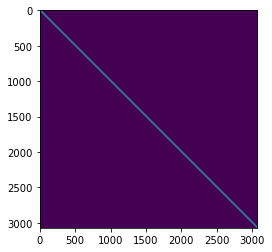

In [17]:
plt.imshow(coupling_nk)

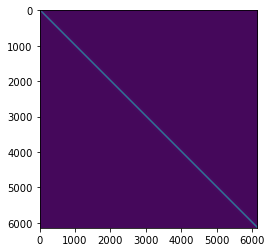

In [18]:
plt.imshow(coupling_gk)